# Unmixing coercivity spectra from backfield curves

## Background on coercivity spectra

Natural samples consists ferromagnetic materials dispersed in paramagnetic and diamagnetic matrix. The ferromagnetic mineral assemblages are usually composed of minerals with different composition, shape, size, such that they have different coercivities. It is common in the fields of rock and environmental magnetism to use backfield magnetic remanence curves to infer for magnetic mineral groups within samples. The experiments involve first applying a strong external field on the sample in one direction to induce a saturation remanence magnetization, and then reverse external field direction and progressively apply stronger fields. The resultant backfield curves are then unmixed to identify different magnetic mineral groups. 

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
# use pmagpy package to parse data
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
# for data table handling
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout
from IPython.display import display, clear_output
import plotly.io as pio

# for statistics
from scipy.stats import skewnorm

from lmfit import Model # for fitting
from lmfit.models import ExponentialModel, GaussianModel, SkewedGaussianModel

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# package and notebook configurations
pd.set_option('display.max_columns', 500)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Download and import data

### Download and unpack data from MagIC

Within the folder `./example_data/backfield_unmixing`, there is a MagIC contribution called `'AX1-1r.TXT'`. Running the code cell below unpacks that MagIC contribution so that we can visualize and analyze the measurement data. We can then create a contribution object that has all of the MagIC tables.

In [2]:
# set the directory path (dir_path) to the data
dir_path = './example_data/backfield_unmixing'

# set the name of the MagIC file
ipmag.unpack_magic('AX1-1r.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

contribution = cb.Contribution(dir_path)

working on:  'specimens\r'
5  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/specimens.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/specimens.txt
working on:  'samples\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/samples.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/samples.txt
working on:  'sites\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/sites.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/sites.txt
working on:  'locations\r'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/locations.txt
  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/backfield_unmixing/locations.txt
wo

### Inspect the measurements table

Within the MagIC contribution object, there is a measurements table that we can inspect.

In [3]:
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all').head() # see the first 5 measurements without empty columns

,experiment,instrument_codes,magn_mass,meas_field_dc,meas_temp,measurement,method_codes,quality,specimen,standard,timestamp,treat_dc_field
measurement name,,,,,,,,,,,,
IRM-VSM2-LP-HYS-216261-1,IRM-VSM2-LP-HYS-216261,IRM-VSM2,0.1285,1.355,300.0,IRM-VSM2-LP-HYS-216261-1,LP-HYS,g,AX1-1r,u,2019:08:15:16:37:00.00,NaN
IRM-VSM2-LP-HYS-216261-2,IRM-VSM2-LP-HYS-216261,IRM-VSM2,0.1286,1.355,300.0,IRM-VSM2-LP-HYS-216261-2,LP-HYS,g,AX1-1r,u,2019:08:15:16:37:00.00,NaN
IRM-VSM2-LP-HYS-216261-3,IRM-VSM2-LP-HYS-216261,IRM-VSM2,0.1286,1.355,300.0,IRM-VSM2-LP-HYS-216261-3,LP-HYS,g,AX1-1r,u,2019:08:15:16:37:00.00,NaN
IRM-VSM2-LP-HYS-216261-4,IRM-VSM2-LP-HYS-216261,IRM-VSM2,0.1286,1.355,300.0,IRM-VSM2-LP-HYS-216261-4,LP-HYS,g,AX1-1r,u,2019:08:15:16:37:00.00,NaN
IRM-VSM2-LP-HYS-216261-5,IRM-VSM2-LP-HYS-216261,IRM-VSM2,0.1288,1.354,300.0,IRM-VSM2-LP-HYS-216261-5,LP-HYS,g,AX1-1r,u,2019:08:15:16:37:00.00,NaN


In [4]:
measurements.method_codes.unique()

array(['LP-HYS', 'LP-BCR-BF'], dtype=object)

## now let's extract the backfield experiment data (LP-BCR-BF) from the measurements table

- the previous cell shows that there are two types of experiments for this specimen
- let's filter for the experiment with a protocol of `LP-BCR-BF` which stands for lab protocol-backfield coercivity remanence-backfield

- columns `magn_mass` and `treat_dc_field` contain the magnetization (mass normalized) and the applied back field respectively.
- they are what we need for coercivity unmixing

In [5]:
# filter for backfield measurements
backfield_measurements = measurements[measurements.method_codes == 'LP-BCR-BF']
# let's drop the empty columns
backfield_measurements = backfield_measurements.dropna(axis=1, how='all')
# let's inspec the data table
backfield_measurements.head()

,experiment,instrument_codes,magn_mass,measurement,method_codes,quality,specimen,standard,timestamp,treat_dc_field
measurement name,,,,,,,,,,
AX1-1rIRM-VSM3-LP-BCR-BF-2162651,IRM-VSM3-LP-BCR-BF-216265,IRM-VSM3,0.01583,AX1-1rIRM-VSM3-LP-BCR-BF-2162651,LP-BCR-BF,g,AX1-1r,300,2019:08:15:18:40:00.00,2.968000e-07
AX1-1rIRM-VSM3-LP-BCR-BF-2162652,IRM-VSM3-LP-BCR-BF-216265,IRM-VSM3,0.01581,AX1-1rIRM-VSM3-LP-BCR-BF-2162652,LP-BCR-BF,g,AX1-1r,300,2019:08:15:18:40:00.00,-9.850000e-05
AX1-1rIRM-VSM3-LP-BCR-BF-2162653,IRM-VSM3-LP-BCR-BF-216265,IRM-VSM3,0.01572,AX1-1rIRM-VSM3-LP-BCR-BF-2162653,LP-BCR-BF,g,AX1-1r,300,2019:08:15:18:40:00.00,-2.057000e-04
AX1-1rIRM-VSM3-LP-BCR-BF-2162654,IRM-VSM3-LP-BCR-BF-216265,IRM-VSM3,0.01565,AX1-1rIRM-VSM3-LP-BCR-BF-2162654,LP-BCR-BF,g,AX1-1r,300,2019:08:15:18:40:00.00,-3.172000e-04
AX1-1rIRM-VSM3-LP-BCR-BF-2162655,IRM-VSM3-LP-BCR-BF-216265,IRM-VSM3,0.01557,AX1-1rIRM-VSM3-LP-BCR-BF-2162655,LP-BCR-BF,g,AX1-1r,300,2019:08:15:18:40:00.00,-4.360000e-04


### let's lot the raw backfield experiment data

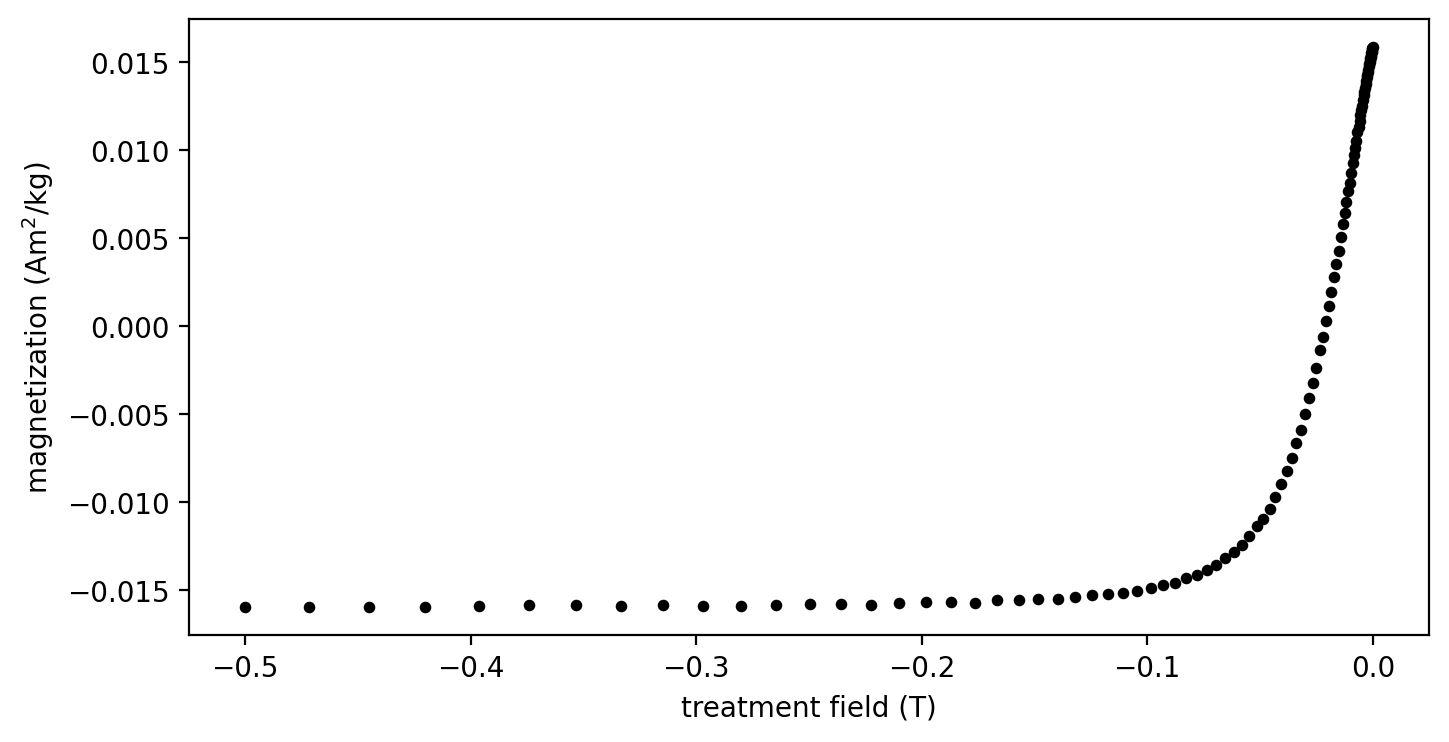

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(backfield_measurements['treat_dc_field'], backfield_measurements['magn_mass'], c='black', marker='o', s=10)

plt.xlabel('treatment field (T)')
plt.ylabel('magnetization (Am$^2$/kg)')
plt.show()

### let's plot the backfield curve in the conventional way

In [7]:
# to plot the backfield data in the conventional way, we need to shift the magnetization to be positive
backfield_measurements['magn_mass_shift'] = [i - backfield_measurements['magn_mass'].min() for i in backfield_measurements['magn_mass']]

# we then calculate the log10 of the treatment fields
backfield_measurements['log_dc_field'] = np.log10(-backfield_measurements['treat_dc_field']*1e3)

# because the first measurement the field was still in the opposite direction, let's drop it
backfield_measurements = backfield_measurements.iloc[1:].reset_index(drop=True)

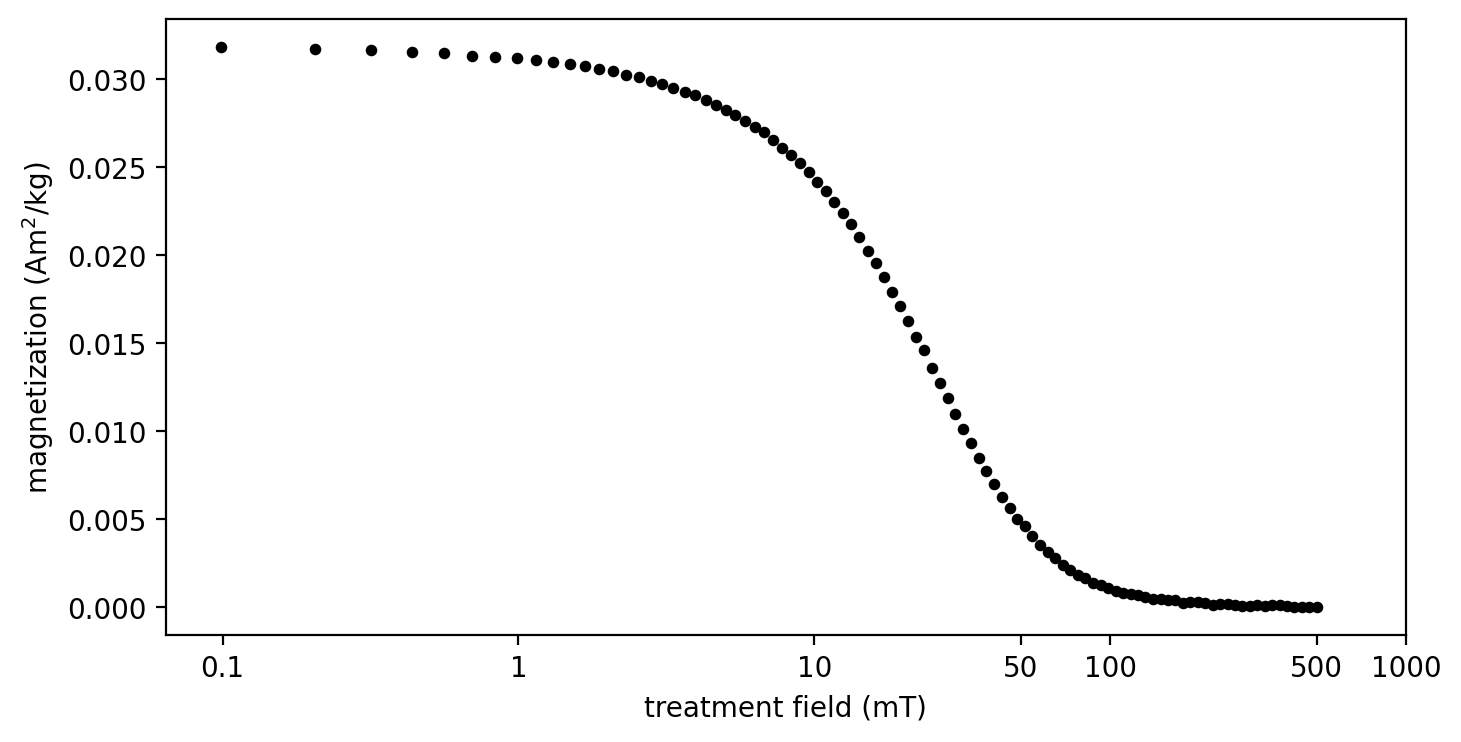

In [8]:
plt.figure(figsize=(8,4))
plt.scatter(backfield_measurements['log_dc_field'], backfield_measurements['magn_mass_shift'], c='black', marker='o', s=10)

# let's make the x ticks easier to read by converting them back to the original values
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])

plt.xlabel('treatment field (mT)')
plt.ylabel('magnetization (Am$^2$/kg)')
plt.show()

### now let's look at the derivatives

- let's take the first derivative of the backfield curve with treatment field in log space and magnetization in shifted space (all positive values)

In [9]:
# let's call the result raw_derivatives since we are doing the action on raw measurement data
raw_derivatives = -np.diff(backfield_measurements['magn_mass_shift'])/np.diff(backfield_measurements['log_dc_field'])

# let's get rid of the first nan value
raw_derivatives_y = raw_derivatives

# we also need to take the middle points of the logB values, and also get rid of the nan values
raw_derivatives_x = backfield_measurements['log_dc_field'].rolling(window=2).mean().dropna()

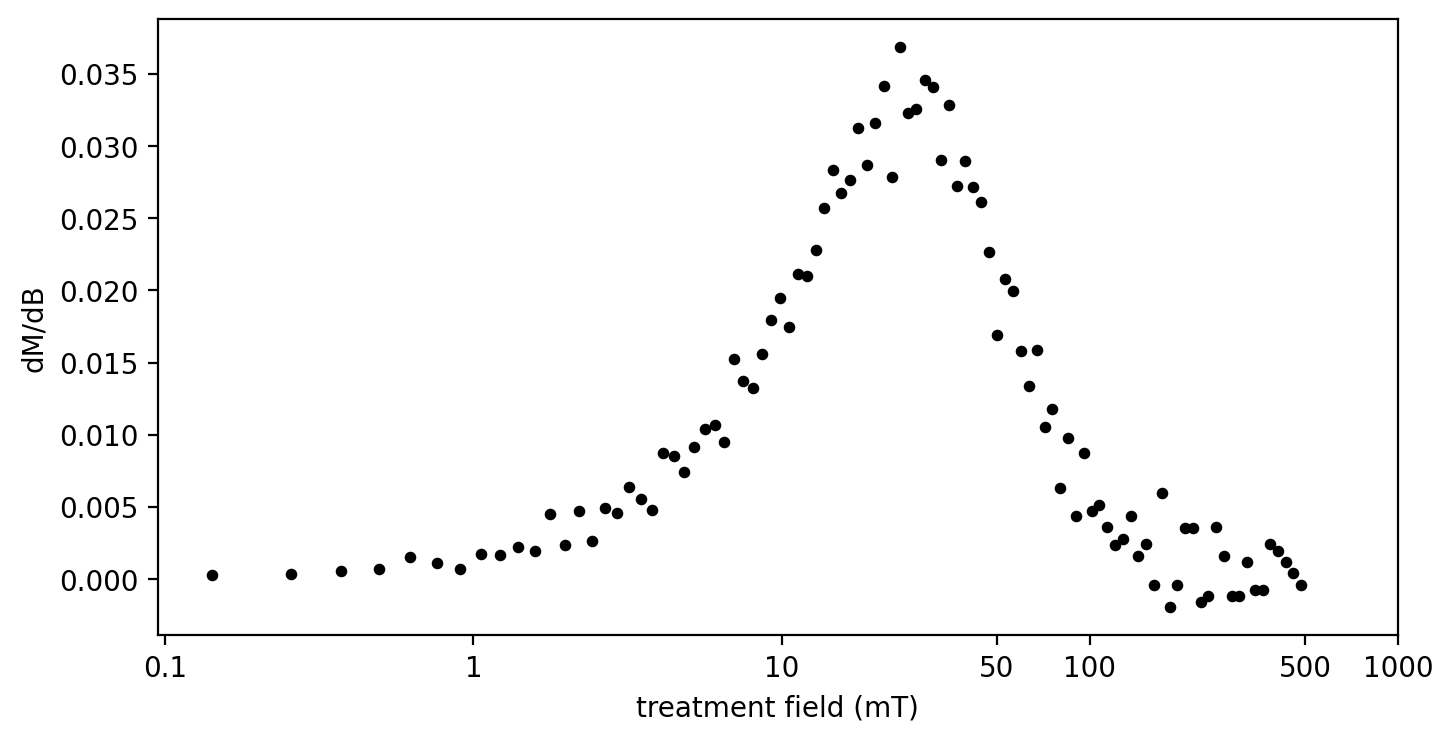

In [10]:
plt.figure(figsize=(8,4))
plt.scatter(raw_derivatives_x, raw_derivatives_y, c='black', marker='o', s=10)

# let's make the x ticks easier to read by converting them back to the original values
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])

plt.xlabel('treatment field (mT)')
plt.ylabel('dM/dB')
plt.show()

## We can see that the coercivity spectrum is quite noisy
- take derivatives of the backfield curve amplifies the noise in the original data
- It is often necessary to remove measurement noise within datasets by the application of a smoothing filter.
- one way to smooth the original backfield dataset is to apply a moving average filter, `lowess`, which is available through the `statsmodels` package

- Note that parameter `frac` controls the fraction of total data points used for smoothing for each moving window. The larger the `frac`, the smoother the curve.

In [11]:
# Toggle the value for frac and see how the backfield and coercivity curve changes
spl = lowess(backfield_measurements['magn_mass_shift'], backfield_measurements['log_dc_field'], frac=0.1)

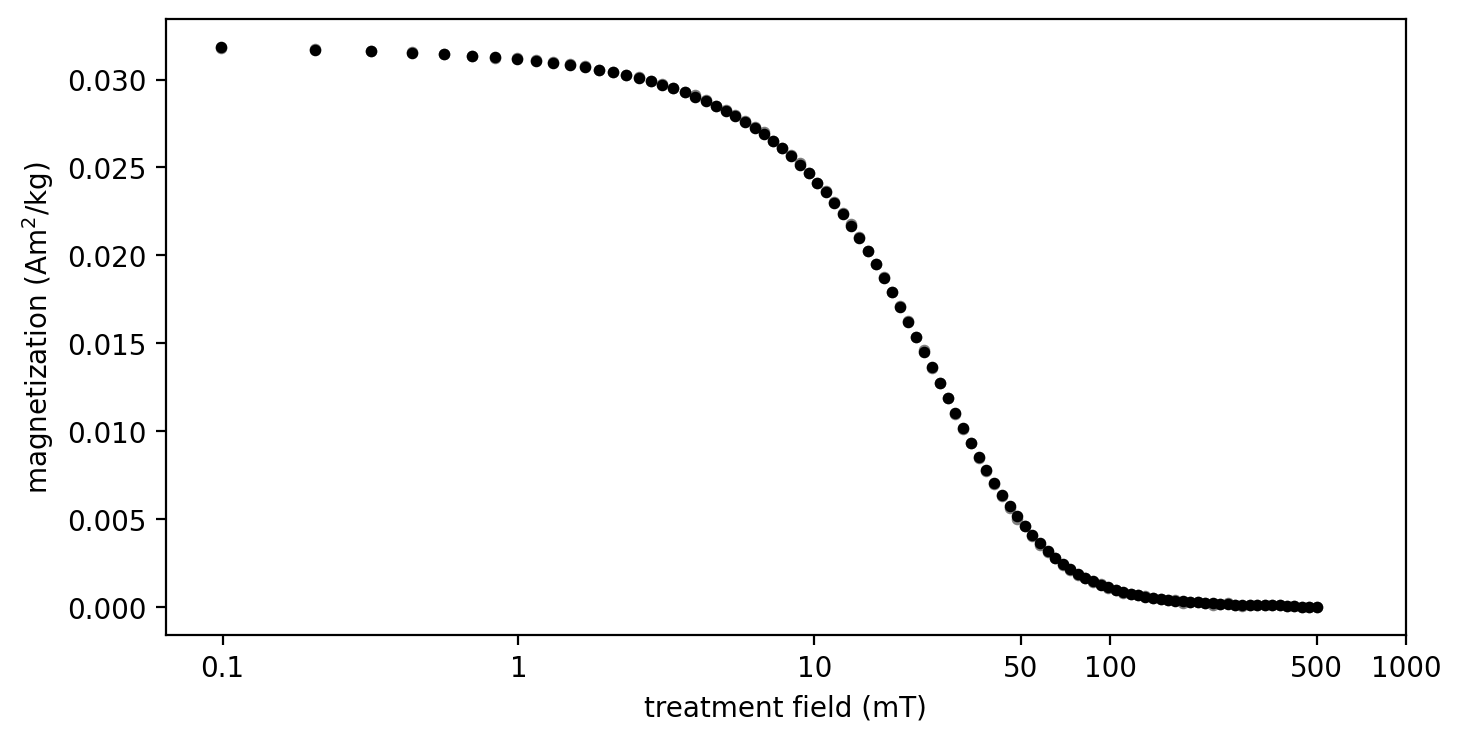

In [12]:
plt.figure(figsize=(8,4))

plt.scatter(backfield_measurements['log_dc_field'], backfield_measurements['magn_mass_shift'], c='grey', marker='o', s=10)
plt.scatter(spl[:, 0], spl[:, 1], c='black', marker='o', s=10)

# let's make the x ticks easier to read by converting them back to the original values
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])

plt.xlabel('treatment field (mT)')
plt.ylabel('magnetization (Am$^2$/kg)')
plt.show()

### Now let's compare the smoothed and unsmoothed coercivity spectra

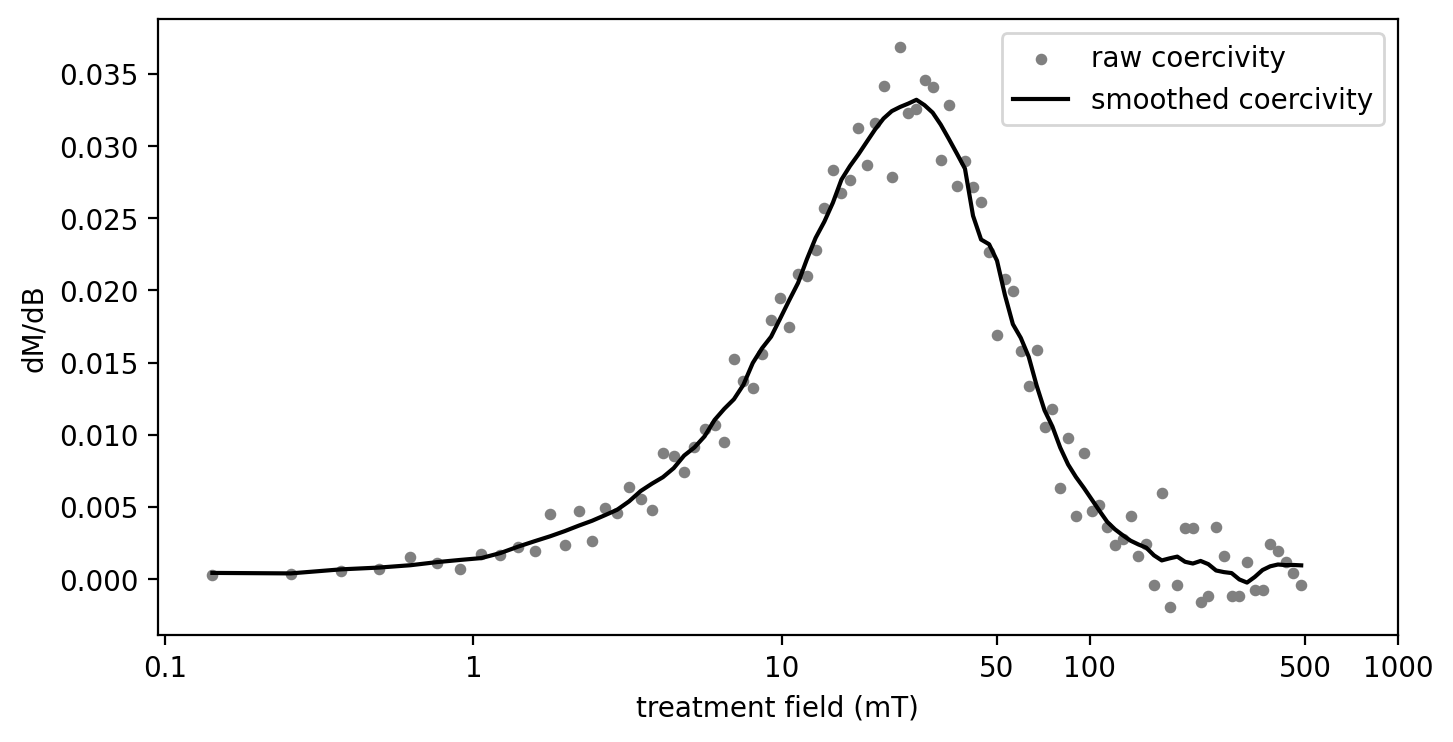

In [13]:
# calculate smoothed derivatives
smoothed_derivatives_y = -np.diff(spl[:, 1])/np.diff(spl[:,0])

plt.figure(figsize=(8,4))
plt.scatter(raw_derivatives_x, raw_derivatives_y, c='grey', marker='o', s=10, label='raw coercivity')
plt.plot(raw_derivatives_x, smoothed_derivatives_y, c='k', label='smoothed coercivity')
# let's make the x ticks easier to read by converting them back to the original values
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])

plt.legend()
plt.xlabel('treatment field (mT)')
plt.ylabel('dM/dB')
plt.show()

## Now iterate through a few smoothing factors and choose the best one

## Now let's move on to unmix the smoothed spectrum into components

- It is a reasonably good assumption that coercivities of a given magnetic mineral grain population can be closely approximated by a log-normal or skewed log-normal distribution (Robertson and France, 1994; Kruiver et al., 2001; Heslop et al., 2002; Egli, 2003, 2004b; Heslop et al., 2004). 


### Let's first use the skewnromal distribution in Scipy to visualize what skewnormal distributions look like

In [14]:
# Create data range
x_values = np.linspace(-10, 10, 1000)

# Create initial Skew Normal distribution with default parameters
initial_location = 0
initial_scale = 1
initial_skewness = 0
initial_y_values = skewnorm.pdf(x_values, a=initial_skewness, loc=initial_location, scale=initial_scale)

# Create Plotly figure
fig = go.FigureWidget()

# Add Skew Normal distribution curve to the figure
fig.add_trace(go.Scatter(x=x_values, y=initial_y_values, mode='lines', name='Skew Normal Distribution'))

# Update layout of the figure
fig.update_layout(title='Skew Normal Distribution',
                  xaxis_title='X',
                  yaxis_title='Probability Density',
                  template='plotly_white')

# Create sliders for parameters
@interact(Location=(-10, 10, 1), Scale=(0, 1, 0.1), Skewness=(-10, 10, 1))
def update(Location=initial_location, Scale=initial_scale, Skewness=initial_skewness):
    # Calculate the Skew Normal distribution with new parameters
    y_values = skewnorm.pdf(x_values, a=Skewness, loc=Location, scale=Scale)
    # Update the data of the figure with new y values
    with fig.batch_update():
        fig.data[0].y = y_values
    return fig


interactive(children=(IntSlider(value=0, description='Location', max=10, min=-10), FloatSlider(value=1.0, desc…

### Now that you know what skewnormal distribution look like, let's try to fit the example spectrum with a skewnormal distribution

- we will use package lmfit to perform the fitting routine

#### single component fit

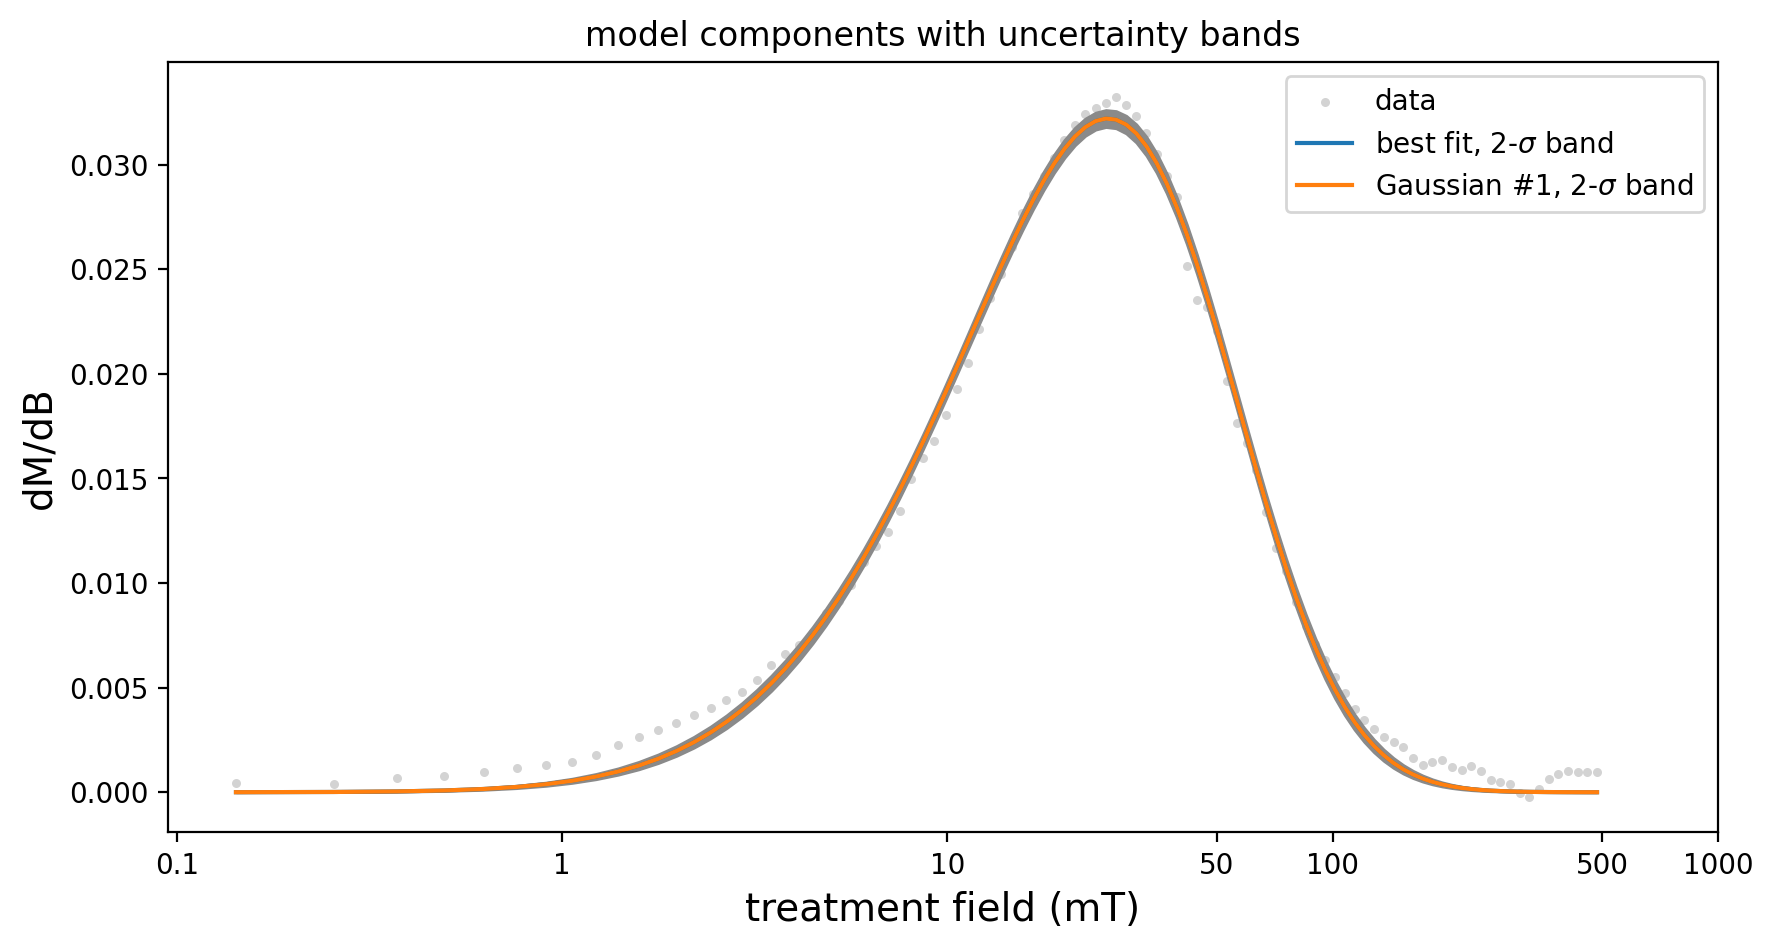

In [15]:
# let's try a single component with background fitting
model = (SkewedGaussianModel(prefix='g1_'))

params = model.make_params(amplitude=0.01,
                            center=1,
                            sigma=1, 
                            gamma=0)

result = model.fit(smoothed_derivatives_y, params, x=raw_derivatives_x)
comps = result.eval_components(x=raw_derivatives_x)
dely = result.eval_uncertainty(sigma=2)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(raw_derivatives_x, smoothed_derivatives_y, c='lightgrey', s=5, label='data')
ax.plot(raw_derivatives_x, result.best_fit, '-', label=r'best fit, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        result.best_fit-dely,
                        result.best_fit+dely,
                        color="#8A8A8A")

ax.plot(raw_derivatives_x, comps['g1_'], label=r'Gaussian #1, 2-$\sigma$ band')

plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])

ax.set_title('model components with uncertainty bands')
plt.xlabel('treatment field (mT)', fontsize=14)
plt.ylabel('dM/dB', fontsize=14)
ax.legend()

plt.show()

In [16]:
result

#### two component fit

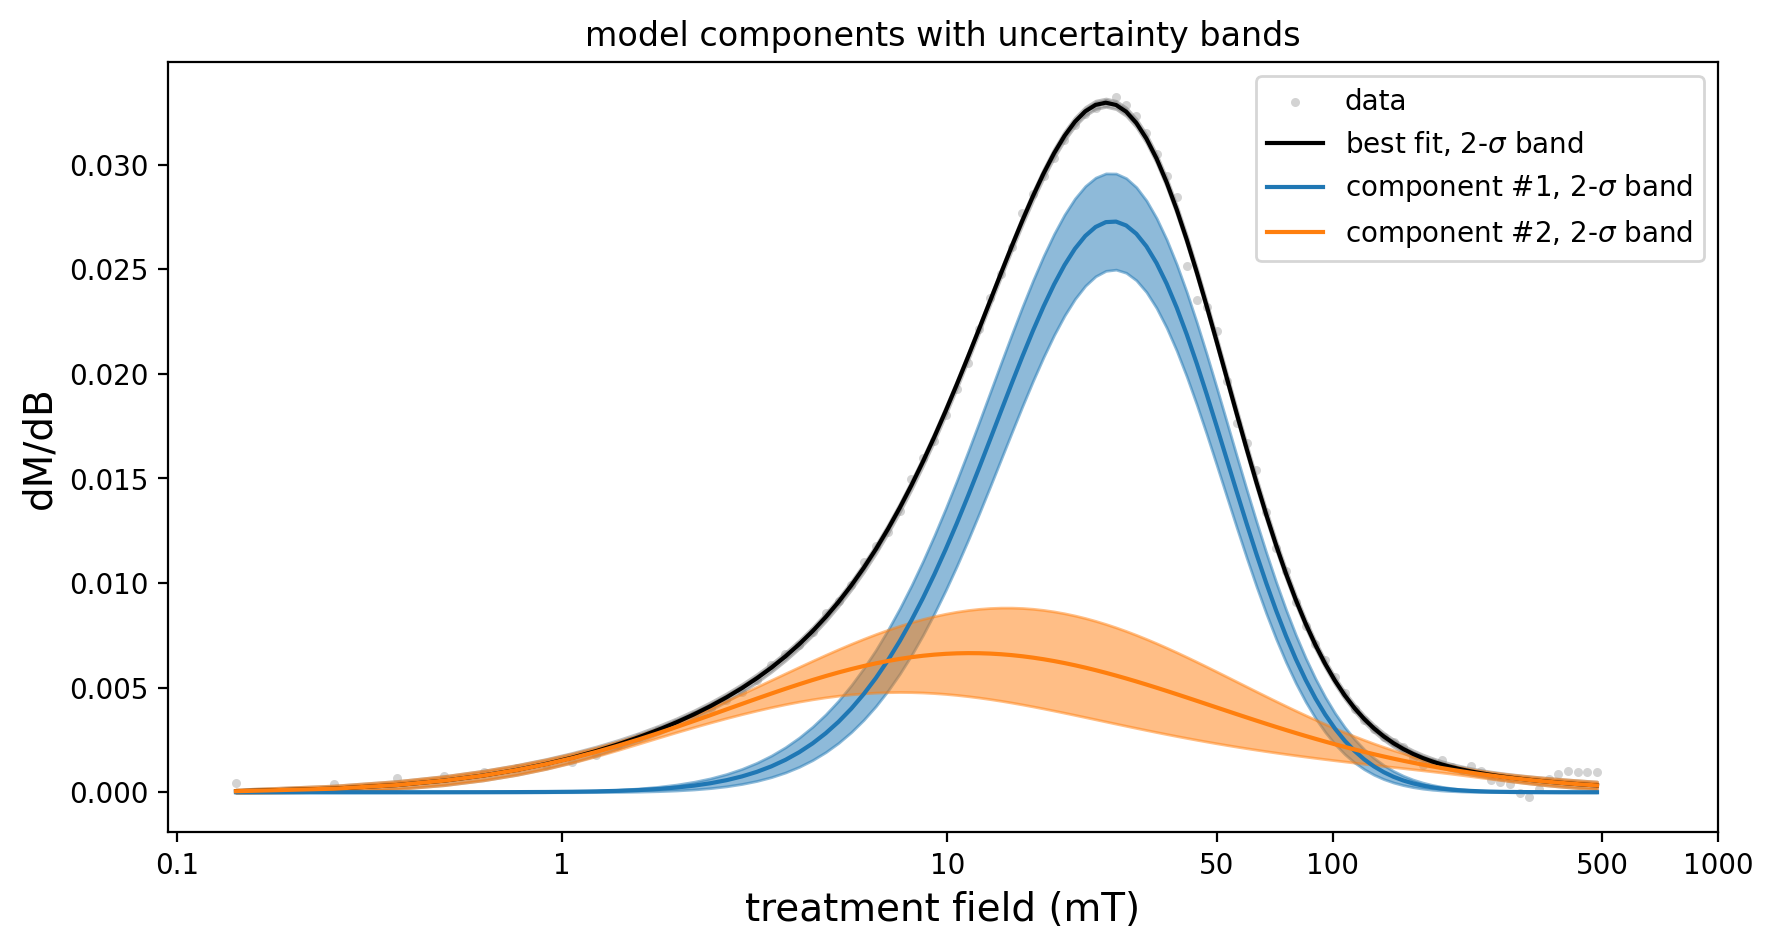

In [17]:
# let's try a single component with background fitting
model = (SkewedGaussianModel(prefix='g1_')+ 
         SkewedGaussianModel(prefix='g2_'))

params = model.make_params(g1_amplitude=0.01,
                            g1_center=1.5,
                            g1_sigma=1, 
                            g1_gamma=0, 
                            g2_amplitude=0.01,
                            g2_center=0.5,
                            g2_sigma=1, 
                            g2_gamma=0)

result = model.fit(smoothed_derivatives_y, params, x=raw_derivatives_x)
comps = result.eval_components(x=raw_derivatives_x)
dely = result.eval_uncertainty(sigma=2)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(raw_derivatives_x, smoothed_derivatives_y, c='lightgrey', s=5, label='data')
ax.plot(raw_derivatives_x, result.best_fit, '-', c='k', label=r'best fit, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        result.best_fit-dely,
                        result.best_fit+dely,
                        color="grey", alpha=0.5)

ax.plot(raw_derivatives_x, comps['g1_'], c='C0', label=r'component #1, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        comps['g1_']-result.dely_comps['g1_'],
                        comps['g1_']+result.dely_comps['g1_'],
                        color="C0", alpha=0.5)

ax.plot(raw_derivatives_x, comps['g2_'], c='C1', label=r'component #2, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        comps['g2_']-result.dely_comps['g2_'],
                        comps['g2_']+result.dely_comps['g2_'],
                        color="C1", alpha=0.5)

ax.set_title('model components with uncertainty bands')
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])
plt.xlabel('treatment field (mT)', fontsize=14)
plt.ylabel('dM/dB', fontsize=14)
ax.legend()

plt.show()

In [18]:
result

#### three component fit?

- it turns out that having a third component is probably too much! The covariance between the parameters of the different components is too much that the fitting routine is not able to converge to a solution. 
- let's stick with the two component fit!

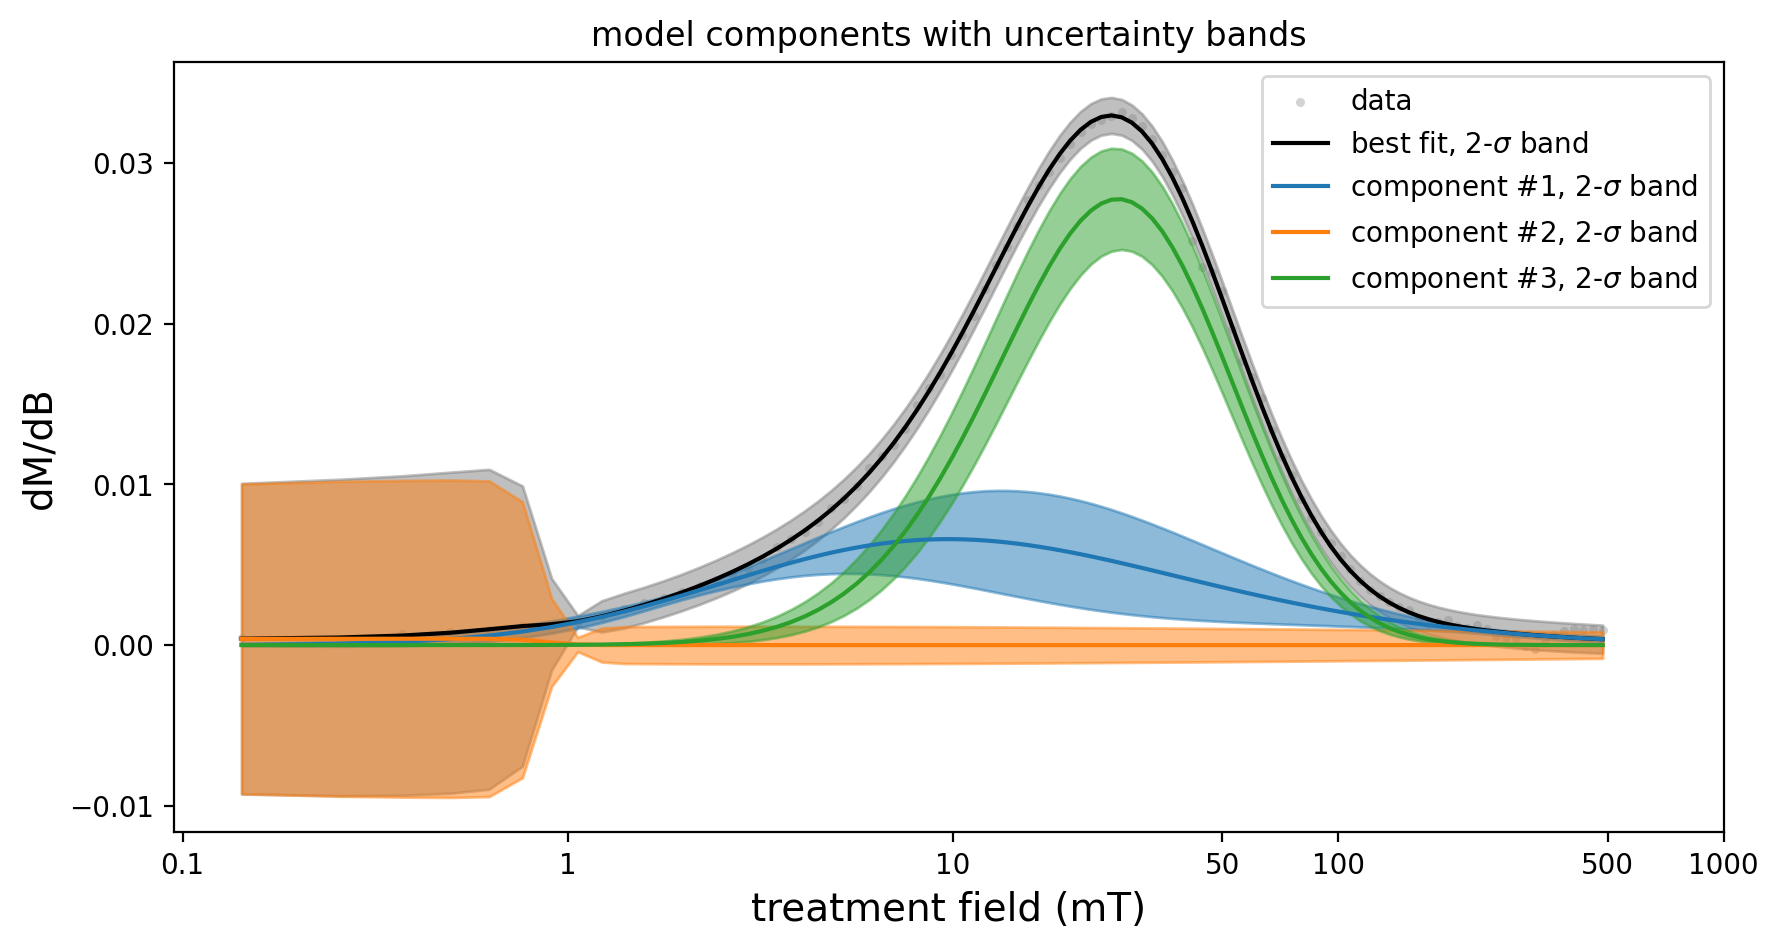

In [19]:
# let's try a single component with background fitting
model = (SkewedGaussianModel(prefix='g1_') + 
         SkewedGaussianModel(prefix='g2_') +
         SkewedGaussianModel(prefix='g3_'))

params = model.make_params(g1_amplitude=0.01,
                            g1_center=1.5,
                            g1_sigma=0.1, 
                            g1_gamma=0, 
                            g2_amplitude=0.01,
                            g2_center=0.4,
                            g2_sigma=0.2, 
                            g2_gamma=0, 
                            g3_amplitude=0.01,
                            g3_center=2,
                            g3_sigma=0.1,
                            g3_gamma=0)

params['g1_amplitude'].min = 0  # Bounds for amplitude parameters
params['g2_amplitude'].min = 0
params['g3_amplitude'].min = 0


params['g1_center'].min = -1  # Bounds for peak centers
params['g2_center'].min = -1
params['g3_center'].min = -1


result = model.fit(smoothed_derivatives_y, params, x=raw_derivatives_x)
comps = result.eval_components(x=raw_derivatives_x)
dely = result.eval_uncertainty(sigma=2)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(raw_derivatives_x, smoothed_derivatives_y, c='lightgrey', s=5, label='data')
ax.plot(raw_derivatives_x, result.best_fit, '-', c='k', label=r'best fit, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        result.best_fit-dely,
                        result.best_fit+dely,
                        color="grey", alpha=0.5)

ax.plot(raw_derivatives_x, comps['g1_'], c='C0', label=r'component #1, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        comps['g1_']-result.dely_comps['g1_'],
                        comps['g1_']+result.dely_comps['g1_'],
                        color="C0", alpha=0.5)

ax.plot(raw_derivatives_x, comps['g2_'], c='C1', label=r'component #2, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        comps['g2_']-result.dely_comps['g2_'],
                        comps['g2_']+result.dely_comps['g2_'],
                        color="C1", alpha=0.5)

ax.plot(raw_derivatives_x, comps['g3_'], c='C2', label=r'component #3, 2-$\sigma$ band')
ax.fill_between(raw_derivatives_x,
                        comps['g3_']-result.dely_comps['g3_'],
                        comps['g3_']+result.dely_comps['g3_'],
                        color="C2", alpha=0.5)

ax.set_title('model components with uncertainty bands')
plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])
plt.xlabel('treatment field (mT)', fontsize=14)
plt.ylabel('dM/dB', fontsize=14)
ax.legend()

plt.show()

In [20]:
result

## Wrap everything into a single function

- to make it easier for batch processing your data, let's wrap everything from data parsing, smoothing, and fitting and plotting into a single function

In [23]:
def coercivity_unmixing(backfield_measurements, frac, num_components=1, params=None):
    '''
    required inputs:
    backfield_measurements: a pandas DataFrame containing the backfield measurements with default columns of
                            raw data of 'treat_dc_field' and 'magn_mass' that are the treatment field and magnetization columns
    frac: the fraction of the data to use for the lowess smoothing          
    num_components: the number of components to fit
    optional inputs:
    params: the initial parameters for the model, provide a dictionary such as
            params = {'g1_amplitude': 0.01,
                      'g1_center': 1.5,
                      'g1_sigma': 0.1, 
                      'g1_gamma': 0, 
                      'g2_amplitude': 0.01,
                      'g2_center': 0.4,
                      'g2_sigma': 0.2, 
                      'g2_gamma': 0, 
                      'g3_amplitude': 0.01,
                      'g3_center': 2,
                      'g3_sigma': 0.1,
                      'g3_gamma': 0}
            note that you should follow the names of the parameters in the example 
    '''

    # to plot the backfield data in the conventional way, we need to shift the magnetization to be positive
    backfield_measurements['magn_mass_shift'] = [i - backfield_measurements['magn_mass'].min() for i in backfield_measurements['magn_mass']]
    # we then calculate the log10 of the treatment fields
    backfield_measurements['log_dc_field'] = np.log10(-backfield_measurements['treat_dc_field']*1e3)
    # because usually in the first measurement the field was still in the opposite direction, let's drop it
    backfield_measurements = backfield_measurements.iloc[1:].reset_index(drop=True)
    # calculate the raw derivatives
    raw_derivatives = -np.diff(backfield_measurements['magn_mass_shift'])/np.diff(backfield_measurements['log_dc_field'])
    # get rid of the first nan value
    raw_derivatives_y = raw_derivatives
    # take the middle points of the logB values, and also get rid of the nan values
    raw_derivatives_x = backfield_measurements['log_dc_field'].rolling(window=2).mean().dropna()
    # calculate the lowess smoothing
    spl = lowess(backfield_measurements['magn_mass_shift'], backfield_measurements['log_dc_field'], frac=frac)
    # calculate the smoothed derivatives
    smoothed_derivatives_y = -np.diff(spl[:, 1])/np.diff(spl[:,0])
    # create the model
    if num_components == 1:
        model = SkewedGaussianModel(prefix='g1_')
        params = model.make_params(amplitude=params['g1_amplitude'],
                                   center=params['g1_center'],
                                   sigma=params['g1_sigma'], 
                                   gamma=params['g1_gamma'])
    elif num_components == 2:
        model = (SkewedGaussianModel(prefix='g1_') + 
                 SkewedGaussianModel(prefix='g2_'))
        params = model.make_params(g1_amplitude=params['g1_amplitude'],
                                   g1_center=params['g1_center'],
                                   g1_sigma=params['g1_sigma'], 
                                   g1_gamma=params['g1_gamma'], 
                                   g2_amplitude=params['g2_amplitude'],
                                   g2_center=params['g2_center'],
                                   g2_sigma=params['g2_sigma'], 
                                   g2_gamma=params['g2_gamma'])
    elif num_components == 3:
        model = (SkewedGaussianModel(prefix='g1_') + 
                 SkewedGaussianModel(prefix='g2_') +
                 SkewedGaussianModel(prefix='g3_'))
        params = model.make_params(g1_amplitude=params['g1_amplitude'],
                                   g1_center=params['g1_center'],
                                   g1_sigma=params['g1_sigma'], 
                                   g1_gamma=params['g1_gamma'], 
                                   g2_amplitude=params['g2_amplitude'],
                                   g2_center=params['g2_center'],
                                   g2_sigma=params['g2_sigma'], 
                                   g2_gamma=params['g2_gamma'], 
                                   g3_amplitude=params['g3_amplitude'],
                                   g3_center=params['g3_center'],
                                   g3_sigma=params['g3_sigma'],
                                   g3_gamma=params['g3_gamma'])
        params['g1_amplitude'].min = 0
        params['g2_amplitude'].min = 0
        params['g3_amplitude'].min = 0
        params['g1_center'].min = -1
        params['g2_center'].min = -1
        params['g3_center'].min = -1
    else:
        raise ValueError('num_components must be 1, 2, or 3')
    # fit the model
    result = model.fit(smoothed_derivatives_y, params, x=raw_derivatives_x)
    # calculate the components
    comps = result.eval_components(x=raw_derivatives_x)
    # calculate the uncertainties
    dely = result.eval_uncertainty(sigma=2)
    # plot the results
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(raw_derivatives_x, smoothed_derivatives_y, c='lightgrey', s=5, label='data')
    ax.plot(raw_derivatives_x, result.best_fit, '-', c='k', label=r'best fit, 2-$\sigma$ band')
    ax.fill_between(raw_derivatives_x,
                            result.best_fit-dely,
                            result.best_fit+dely,
                            color="grey", alpha=0.5)
    for i in range(num_components):
        ax.plot(raw_derivatives_x, comps[f'g{i+1}_'], label=f'component #{i+1}, 2-$\sigma$ band')
        ax.fill_between(raw_derivatives_x,
                            comps[f'g{i+1}_']-result.dely_comps[f'g{i+1}_'],
                            comps[f'g{i+1}_']+result.dely_comps[f'g{i+1}_'],
                            alpha=0.5)
    ax.set_title('model components with uncertainty bands')
    plt.xticks(ticks=np.log10([0.1, 1, 10, 50, 100, 500, 1000]), labels=[0.1, 1, 10, 50, 100, 500, 1000])
    plt.xlabel('treatment field (mT)', fontsize=14)
    plt.ylabel('dM/dB', fontsize=14)
    ax.legend()
    plt.show()
    return result



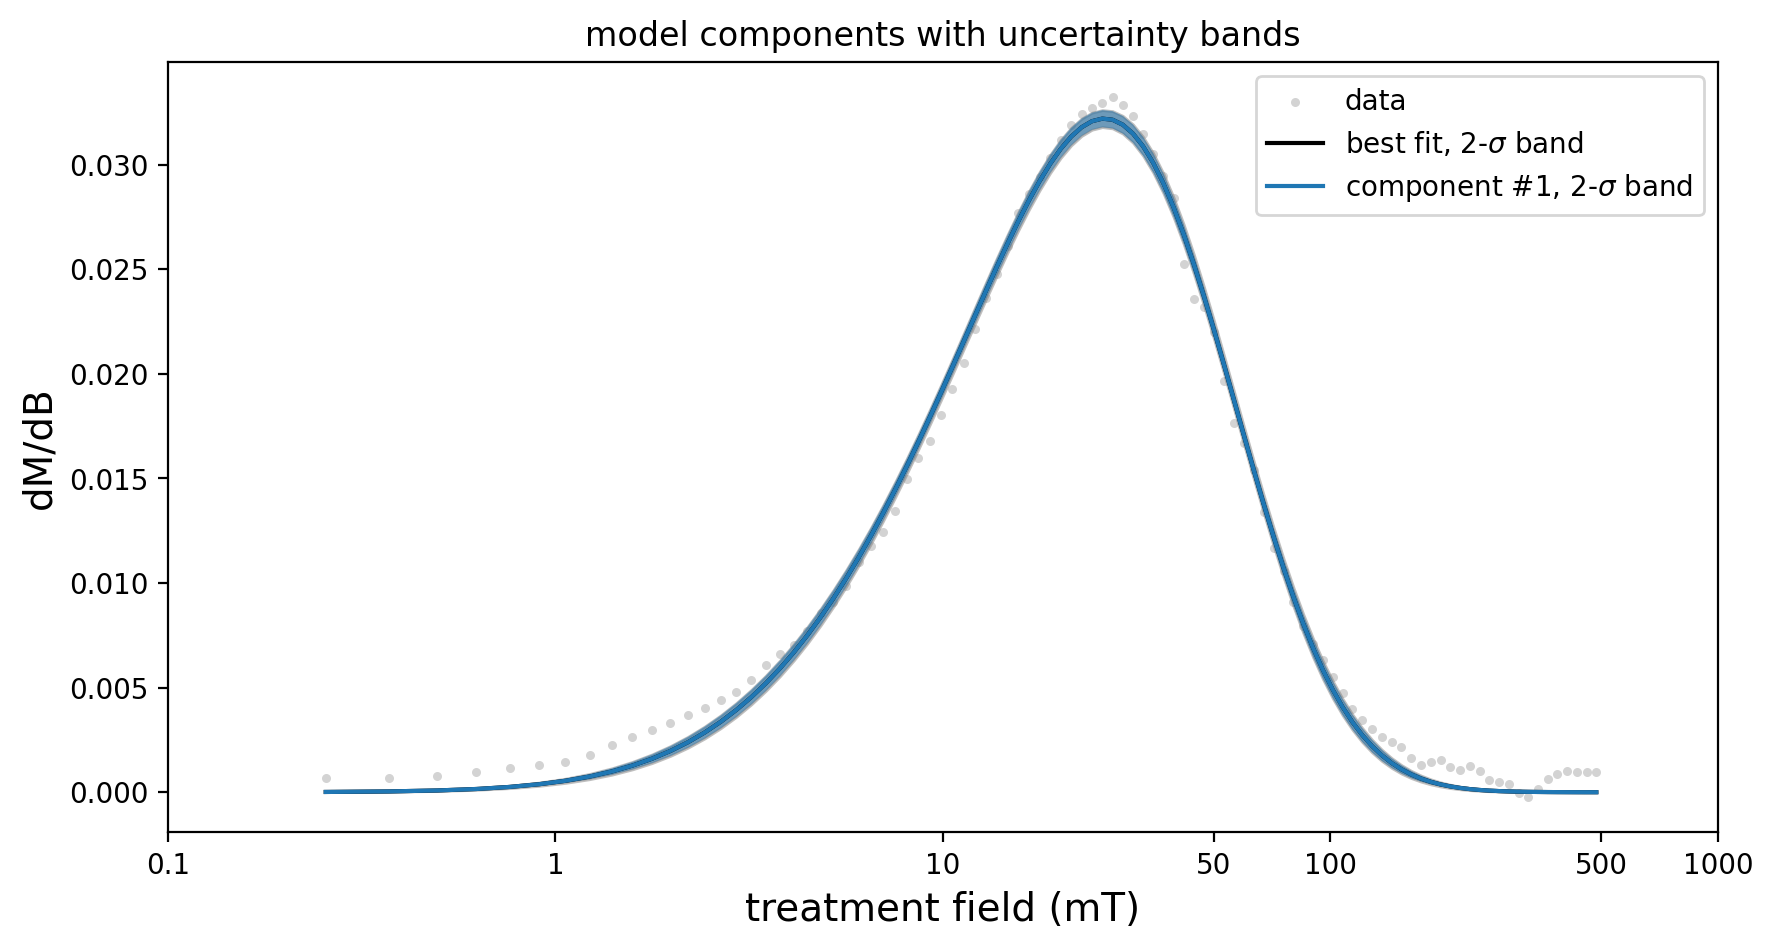

In [24]:
coercivity_unmixing(backfield_measurements, frac=0.1, num_components=1, params={'g1_amplitude': 0.01,
                                                                                'g1_center': 1.5,
                                                                               'g1_sigma': 0.1, 
                                                                               'g1_gamma': 0})